In [1]:
import carla
import random
import time
import numpy as np
import queue
import cv2

# Connect to the client and retrieve the world object
client = carla.Client('localhost', 2000)
client.set_timeout(2.0)
world = client.get_world()


In [2]:
# Load layered map for Town 01 with minimum layout plus buildings and parked vehicles
world = client.load_world('Town02_Opt', carla.MapLayer.Buildings | carla.MapLayer.ParkedVehicles)
# Toggle all buildings off
world.unload_map_layer(carla.MapLayer.Buildings)
# Toggle all buildings on   
world.load_map_layer(carla.MapLayer.Buildings)
#world = client.load_world('Town02')


Actor意味演员，在仿真世界里则代表可以移动的物体，包括汽车，传感器（因为传感器要安在车身上）以及行人。
生成（spawn) Actor


In [3]:
# 拿到这个世界所有物体的蓝图
blueprint_library = world.get_blueprint_library()

In [4]:
# 从浩瀚如海的蓝图中找到奔驰的蓝图
target_vehicle_bp = blueprint_library.find('vehicle.toyota.prius')
agent_vehicle_bp = blueprint_library.find('vehicle.mini.cooper_s')


In [5]:
# 找到所有可以作为初始点的位置并随机选择一个
transform1 = random.choice(world.get_map().get_spawn_points())
transform2 = random.choice(world.get_map().get_spawn_points())

# 在这个位置生成汽车
target_vehicle_bp = world.spawn_actor(target_vehicle_bp, transform1)
agent_vehicle_bp = world.spawn_actor(agent_vehicle_bp, transform2)

In [6]:
# 把它设置成自动驾驶模式
target_vehicle_bp .set_autopilot(True)
agent_vehicle_bp .set_autopilot(True)

Camera构建
与汽车类似，我们先创建蓝图，再定义位置，然后再选择我们想要的汽车安装上去。不过，这里的位置都是相对汽车中心点的位置（以米计量）。

In [7]:
# Find the blueprint of the sensor.
rgb_camera_bp = world.get_blueprint_library().find('sensor.camera.rgb')
rgb_camera_bp.set_attribute('image_size_x', '1920')
rgb_camera_bp.set_attribute('image_size_y', '1080')
rgb_camera_bp.set_attribute('fov', '110')
# Set the time in seconds between sensor captures
rgb_camera_bp.set_attribute('sensor_tick', '1.0')

In [8]:
depth_camera_bp = world.get_blueprint_library().find('sensor.camera.depth')
depth_camera_bp.set_attribute('image_size_x', '1920')
depth_camera_bp.set_attribute('image_size_y', '1080')
depth_camera_bp.set_attribute('fov', '110')
# Set the time in seconds between sensor captures
depth_camera_bp.set_attribute('sensor_tick', '1.0')

In [9]:
segmentation_camera_bp = world.get_blueprint_library().find('sensor.camera.semantic_segmentation')
segmentation_camera_bp.set_attribute('image_size_x', '1920')
segmentation_camera_bp.set_attribute('image_size_y', '1080')
segmentation_camera_bp.set_attribute('fov', '110')
# Set the time in seconds between sensor captures
segmentation_camera_bp.set_attribute('sensor_tick', '1.0')

In [79]:
camera_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
rgb_camera = world.spawn_actor(rgb_camera_bp, camera_transform, attach_to=agent_vehicle_bp, attachment_type=carla.AttachmentType.Rigid)
image_queue = queue.Queue()
rgb_camera.listen(image_queue.put)


depth_camera = world.spawn_actor(depth_camera_bp, camera_transform, attach_to=agent_vehicle_bp, attachment_type=carla.AttachmentType.Rigid)
image_queue_depth = queue.Queue()
depth_camera.listen(image_queue_depth.put)


segmentation_camera = world.spawn_actor(segmentation_camera_bp, camera_transform, attach_to=agent_vehicle_bp, attachment_type=carla.AttachmentType.Rigid)
image_queue_seg = queue.Queue()
segmentation_camera.listen(image_queue_seg.put)

当我们去观察仿真界面时，我们会发现，自己的视野并不会随我们造的小车子移动，所以经常会跟丢它。解决这个问题的办法就是把spectator对准汽车，这样小汽车就永远在我们的视野里了！



In [17]:
spectator = world.get_spectator()
transform = agent_vehicle_bp.get_transform()
spectator.set_transform(carla.Transform(transform.location + carla.Location(z=10),
                                                    carla.Rotation(pitch=-40)))


我们还要对相机定义它的callback function,定义每次仿真世界里传感器数据传回来后，我们要对它进行什么样的处理。在这个教程里我们只需要简单地将文件存在硬盘里。



In [20]:
#rgb_camera.listen(lambda image: image.save_to_disk(os.path.join("/mnt/sda1/carla/fov", '%06d.png' % image.frame)))


In [17]:
#segmentation_camera.listen(lambda image: image.save_to_disk("/mnt/sda1/carla/seg/%06d_semseg.png" %(image.frame), carla.ColorConverter.CityScapesPalette))


In [ ]:
#depth_camera.listen(lambda image: image.save_to_disk("/mnt/sda1/carla/dep/%06d_semseg.png" %(image.frame), carla.ColorConverter.LogarithmicDepth))


In [81]:
world.tick() #runs one step of the simulation.
#rgb camera
image = image_queue.get()
#semantic segmentation camera
image_seg  = image_queue_seg.get()
#depth camera
image_depth = image_queue_depth.get()
image.save_to_disk("/mnt/sda1/carla/fov/%06d.png" %(image.frame))
image_seg.save_to_disk("/mnt/sda1/carla/seg/%06d_semseg.png" %(image.frame), carla.ColorConverter.CityScapesPalette)
image_depth.save_to_disk("/mnt/sda1/carla/dep/%06d_depth.png" %(image.frame), carla.ColorConverter.LogarithmicDepth)




'/mnt/sda1/carla/dep/325764_depth.png'

In [6]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


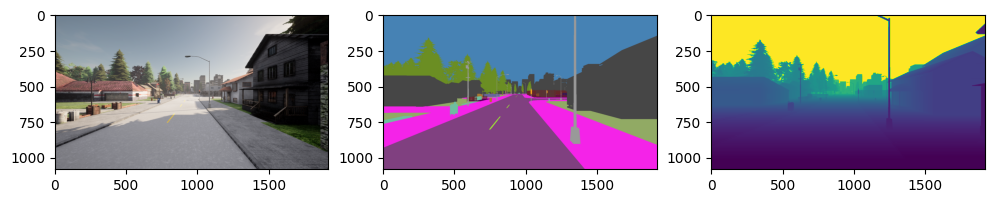

In [82]:
img = mpimg.imread("/mnt/sda1/carla/fov/%06d.png" % image.frame)
img_semseg = mpimg.imread("/mnt/sda1/carla/seg/%06d_semseg.png" % image.frame)
img_depth = mpimg.imread("/mnt/sda1/carla/dep/%06d_depth.png" % image.frame)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,18))
ax1.imshow(img)
ax2.imshow(img_semseg)
ax3.imshow(img_depth) 
plt.show()

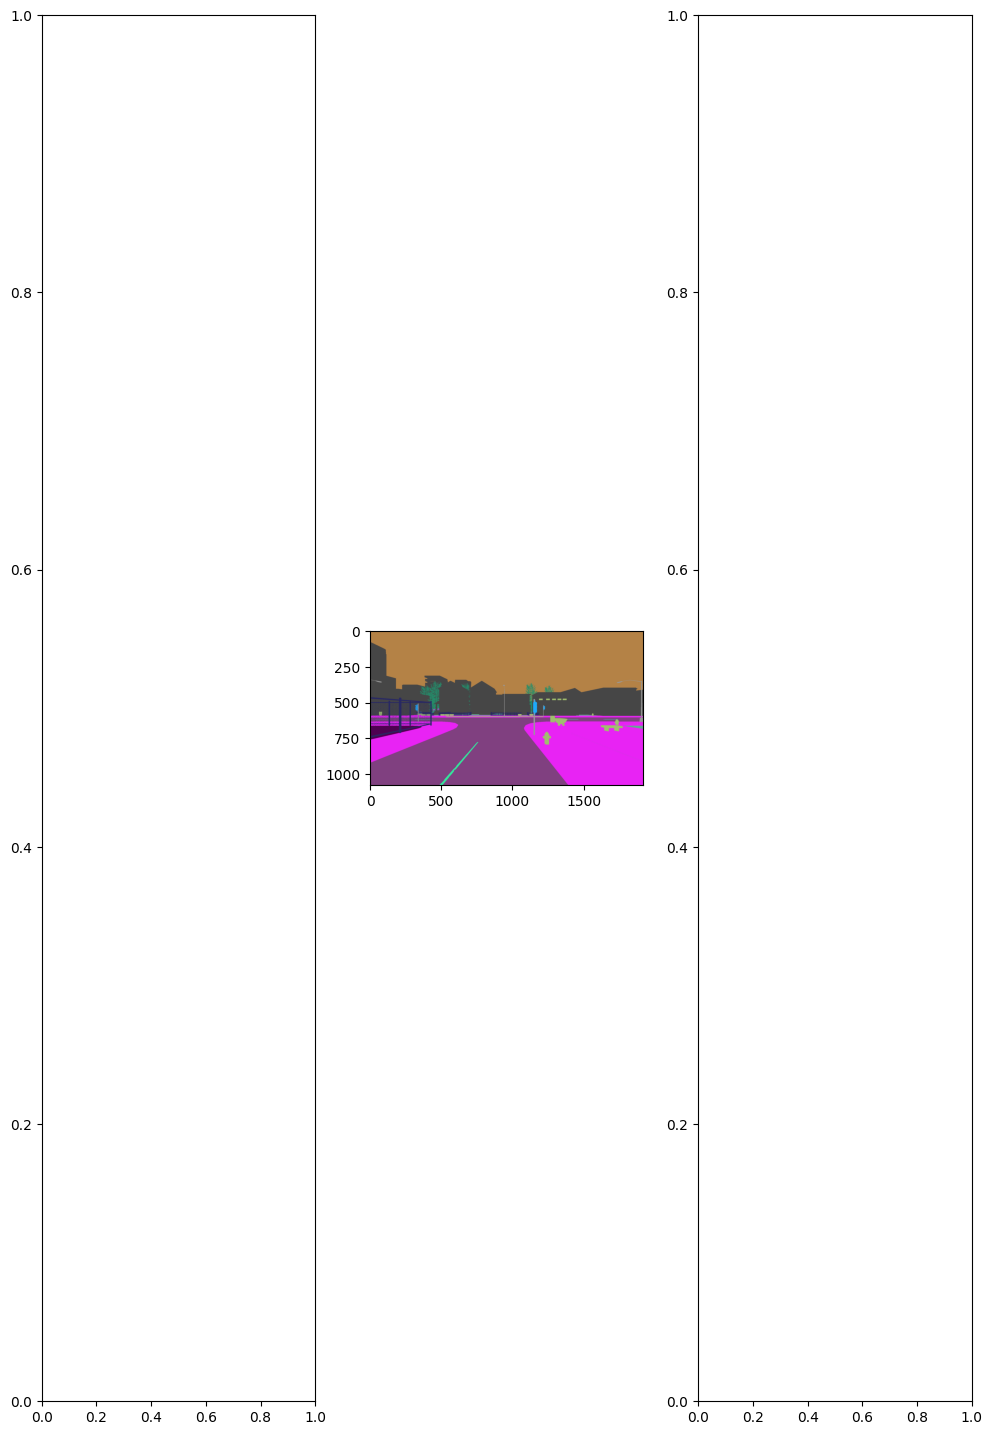

In [88]:
#img_semseg_bgr = cv2.imread("/mnt/sda1/carla/seg/%06d_semseg.png" % image.frame)
img_semseg_bgr = cv2.imread("/mnt/sda1/carla/seg/001845_semseg.png" )
img_semseg_bgr = cv2.cvtColor(img_semseg_bgr, cv2.COLOR_BGRA2BGR)
img_semseg_hsv = cv2.cvtColor(img_semseg_bgr, cv2.COLOR_BGR2HSV) # color wise segmentation is better in hsv space
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,18))
ax2.imshow(img_semseg_bgr)

plt.show()

In [89]:
img_semseg_hsv = cv2.cvtColor(np.array(image_seg.raw_data).reshape((1080, 1920, 4)), cv2.COLOR_BGR2HSV)

NameError: name 'image_seg' is not defined

In [54]:
import skimage.measure as measure


In [95]:
def get_mask(seg_im, rgb_value):
    # rgb_value should be somethiing like np.uint8([[[70, 70, 70]]])
    # seg_im should be in HSV
    
    hsv_value = cv2.cvtColor(rgb_value, cv2.COLOR_RGB2HSV)
    
    hsv_low = np.array([[[hsv_value[0][0][0]-5, hsv_value[0][0][1], hsv_value[0][0][2]-5]]])
    hsv_high = np.array([[[hsv_value[0][0][0]+5, hsv_value[0][0][1], hsv_value[0][0][2]+5]]])
    
    mask = cv2.inRange(seg_im, hsv_low, hsv_high)
    return mask.any()


In [83]:
object_list = dict()
object_list['car'] = np.uint8([[[ 0, 0, 142]]])


In [96]:
mask = get_mask(img_semseg_hsv, object_list['car'])
mask

False

In [ ]:
sensor.listen(lambda data: process_img(data))
